In [1]:
import os

from cmeutils.structure import gsd_rdf, bond_distribution, nematic_order_parameter
from cmeutils.polymers import end_to_end_distance, radius_of_gyration
from cmeutils.dynamics import msd_from_gsd
from cmeutils.sampling import autocorr1D
from cmeutils.plotting import get_histogram
from cmeutils.plotting import savitzky_golay
from cmeutils.gsd_utils import get_molecule_cluster

import freud
import matplotlib.pyplot as plt
import numpy as np
import signac

import gsd.hoomd

color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "x", 0.7: "^", 0.6: "*"}

plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 4
plt.rcParams['lines.markersize'] = 2
plt.rcParams["lines.linestyle"] = "-"
#plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
project = signac.get_project("../coarse-grain-sims/lattice-annealing/nvt/bulk-relaxation-long/polybinder-flow/")

In [3]:
def frames_to_ns(real_timestep, frame_counts, frame_write_freq):
    ns_timestep = real_timestep * 1e-6
    return np.array(frame_counts) * frame_write_freq * ns_timestep

# Nematic Order Parameter:

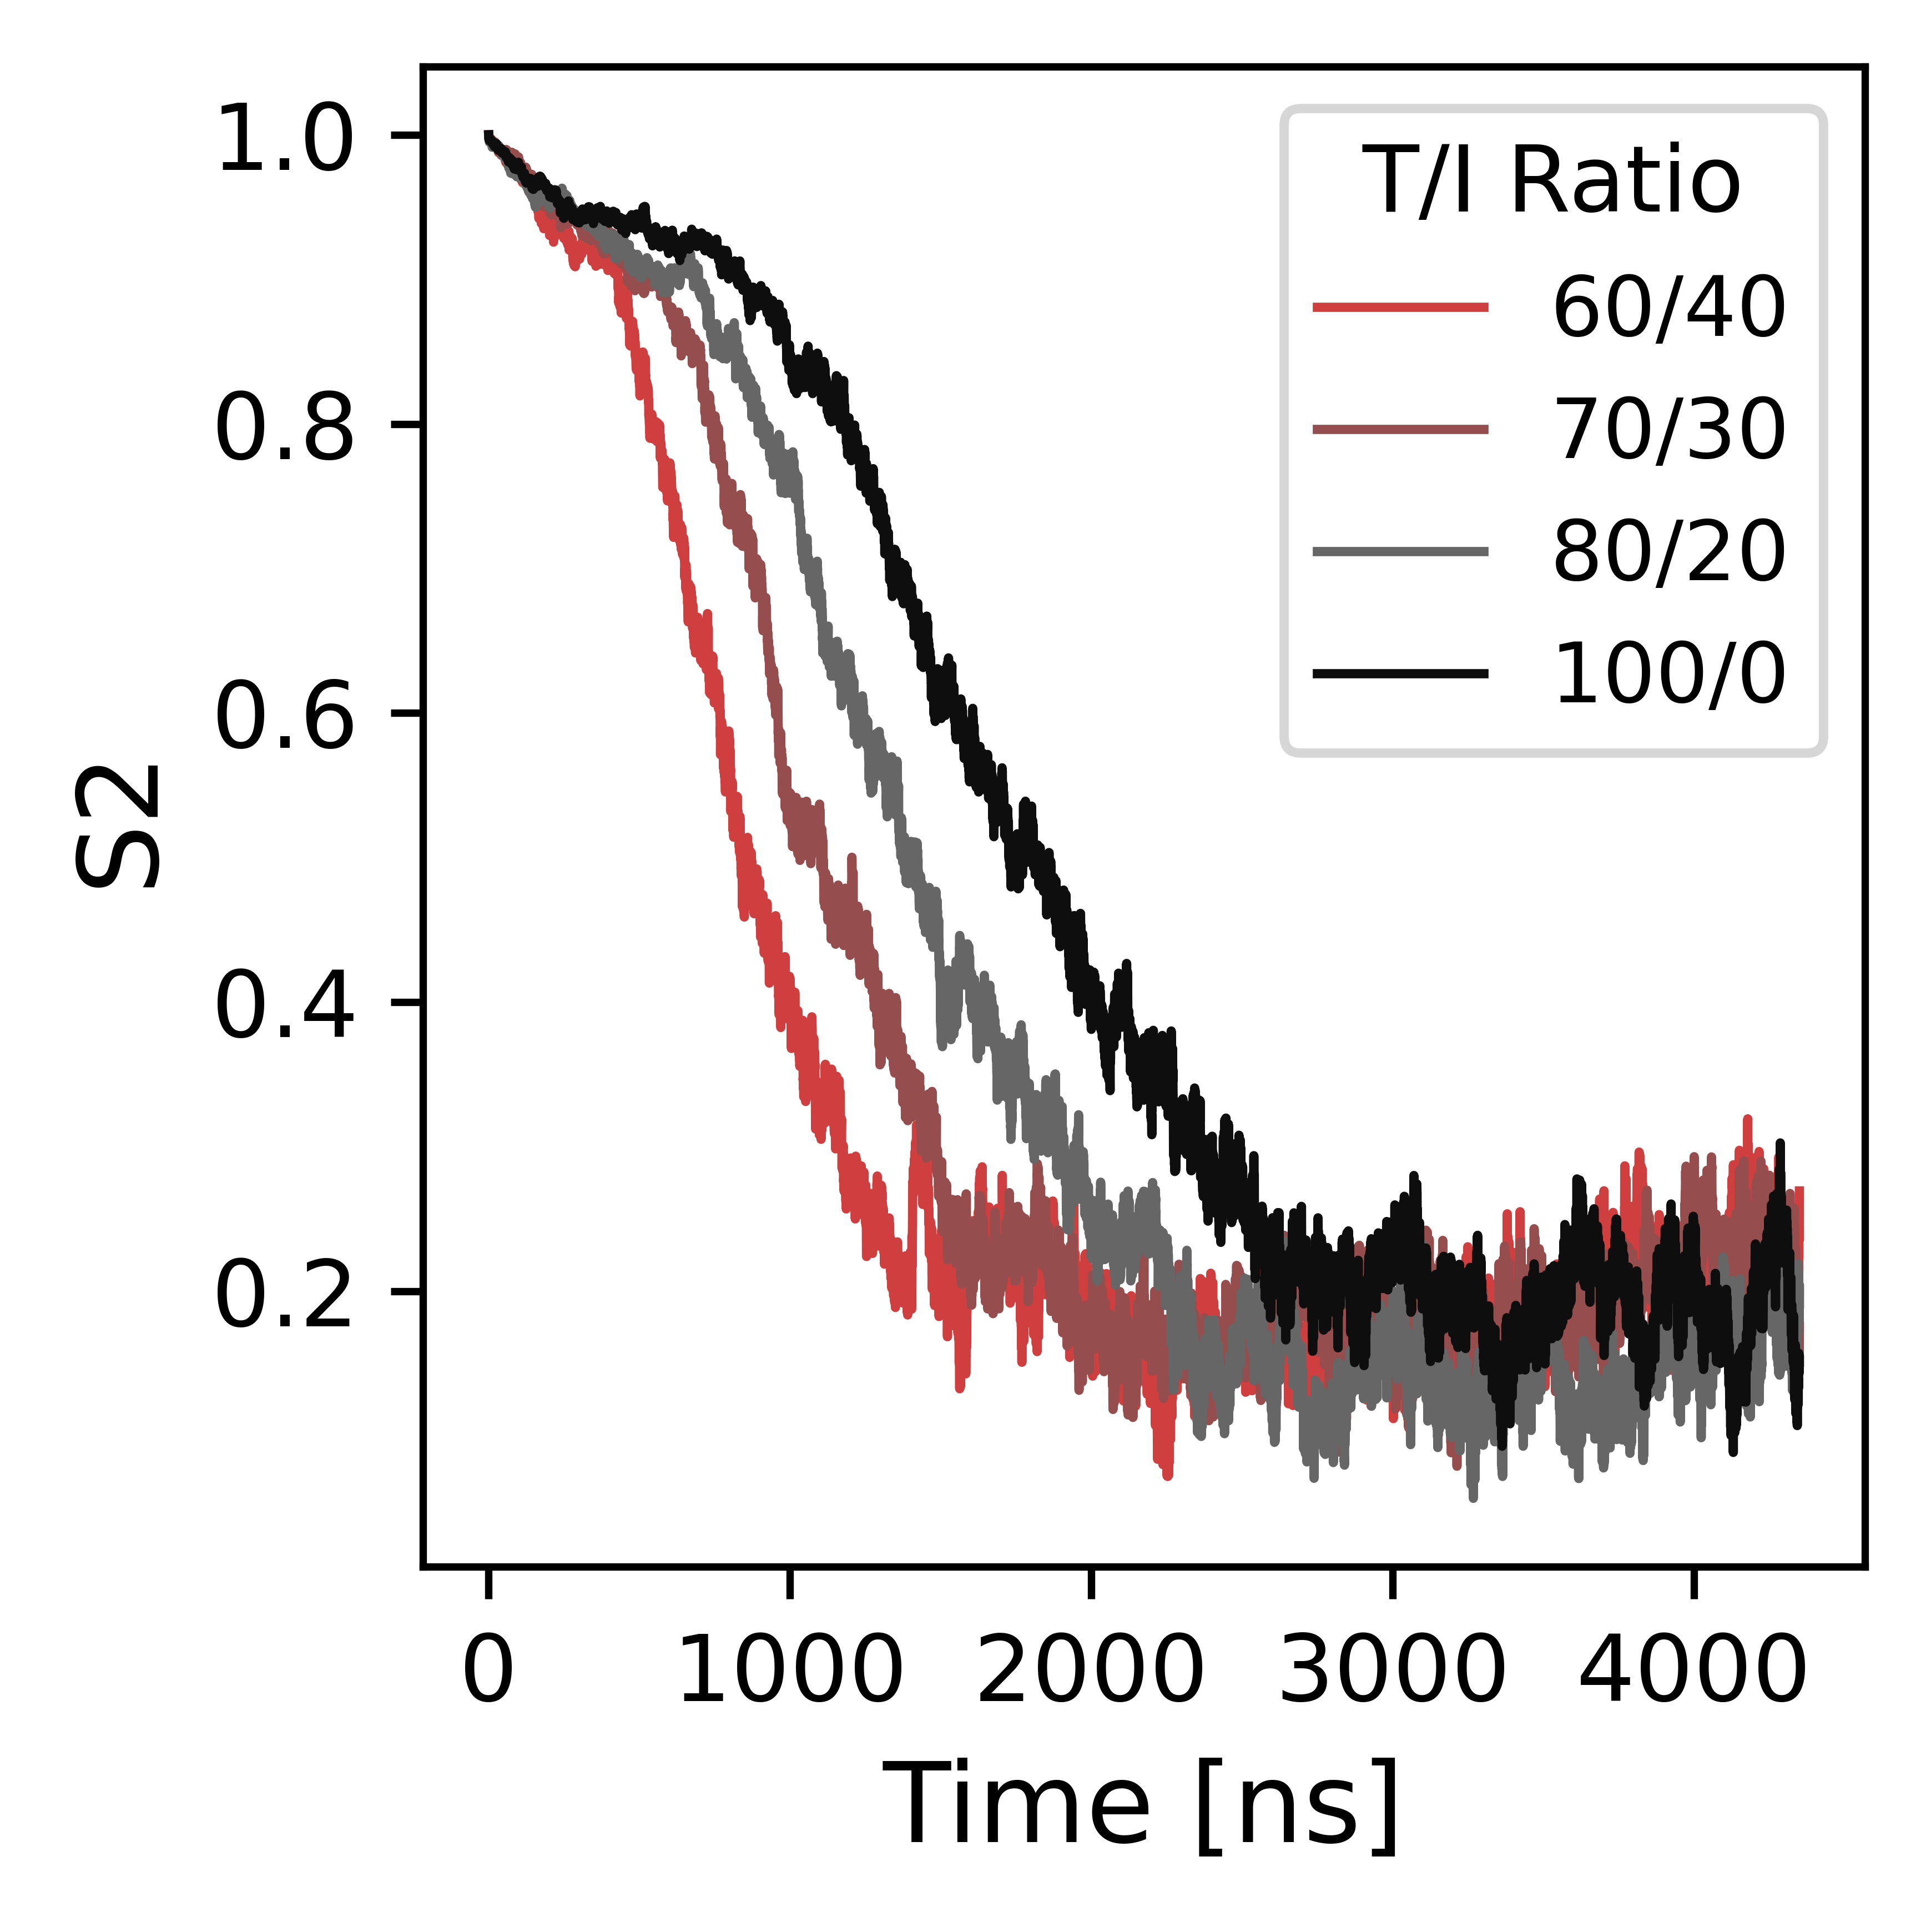

In [7]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": 2.0, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"):
    
    for job in jobs:
        if ti_ratio == 0.60:
            label="60/40"
        elif ti_ratio == 0.70:
            label="70/30"
        elif ti_ratio == 0.80:
            label="80/20"
        elif ti_ratio == 1.0:
            label="100/0"
        nem_order = np.loadtxt(job.fn("nem_order.txt"))
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(nem_order)), job.sp.gsd_write)
        plt.plot(ns, nem_order, label=label, c=color_dict[ti_ratio])
        #print(job.ws)
        
plt.legend(title="T/I Ratio", fontsize=9)

plt.xlabel("Time [ns]")
plt.ylabel("S2")
plt.tight_layout()
plt.savefig("figures/s2-order-parm-decay-2.0kT.png")
plt.show()

# Plot Experimental Results:

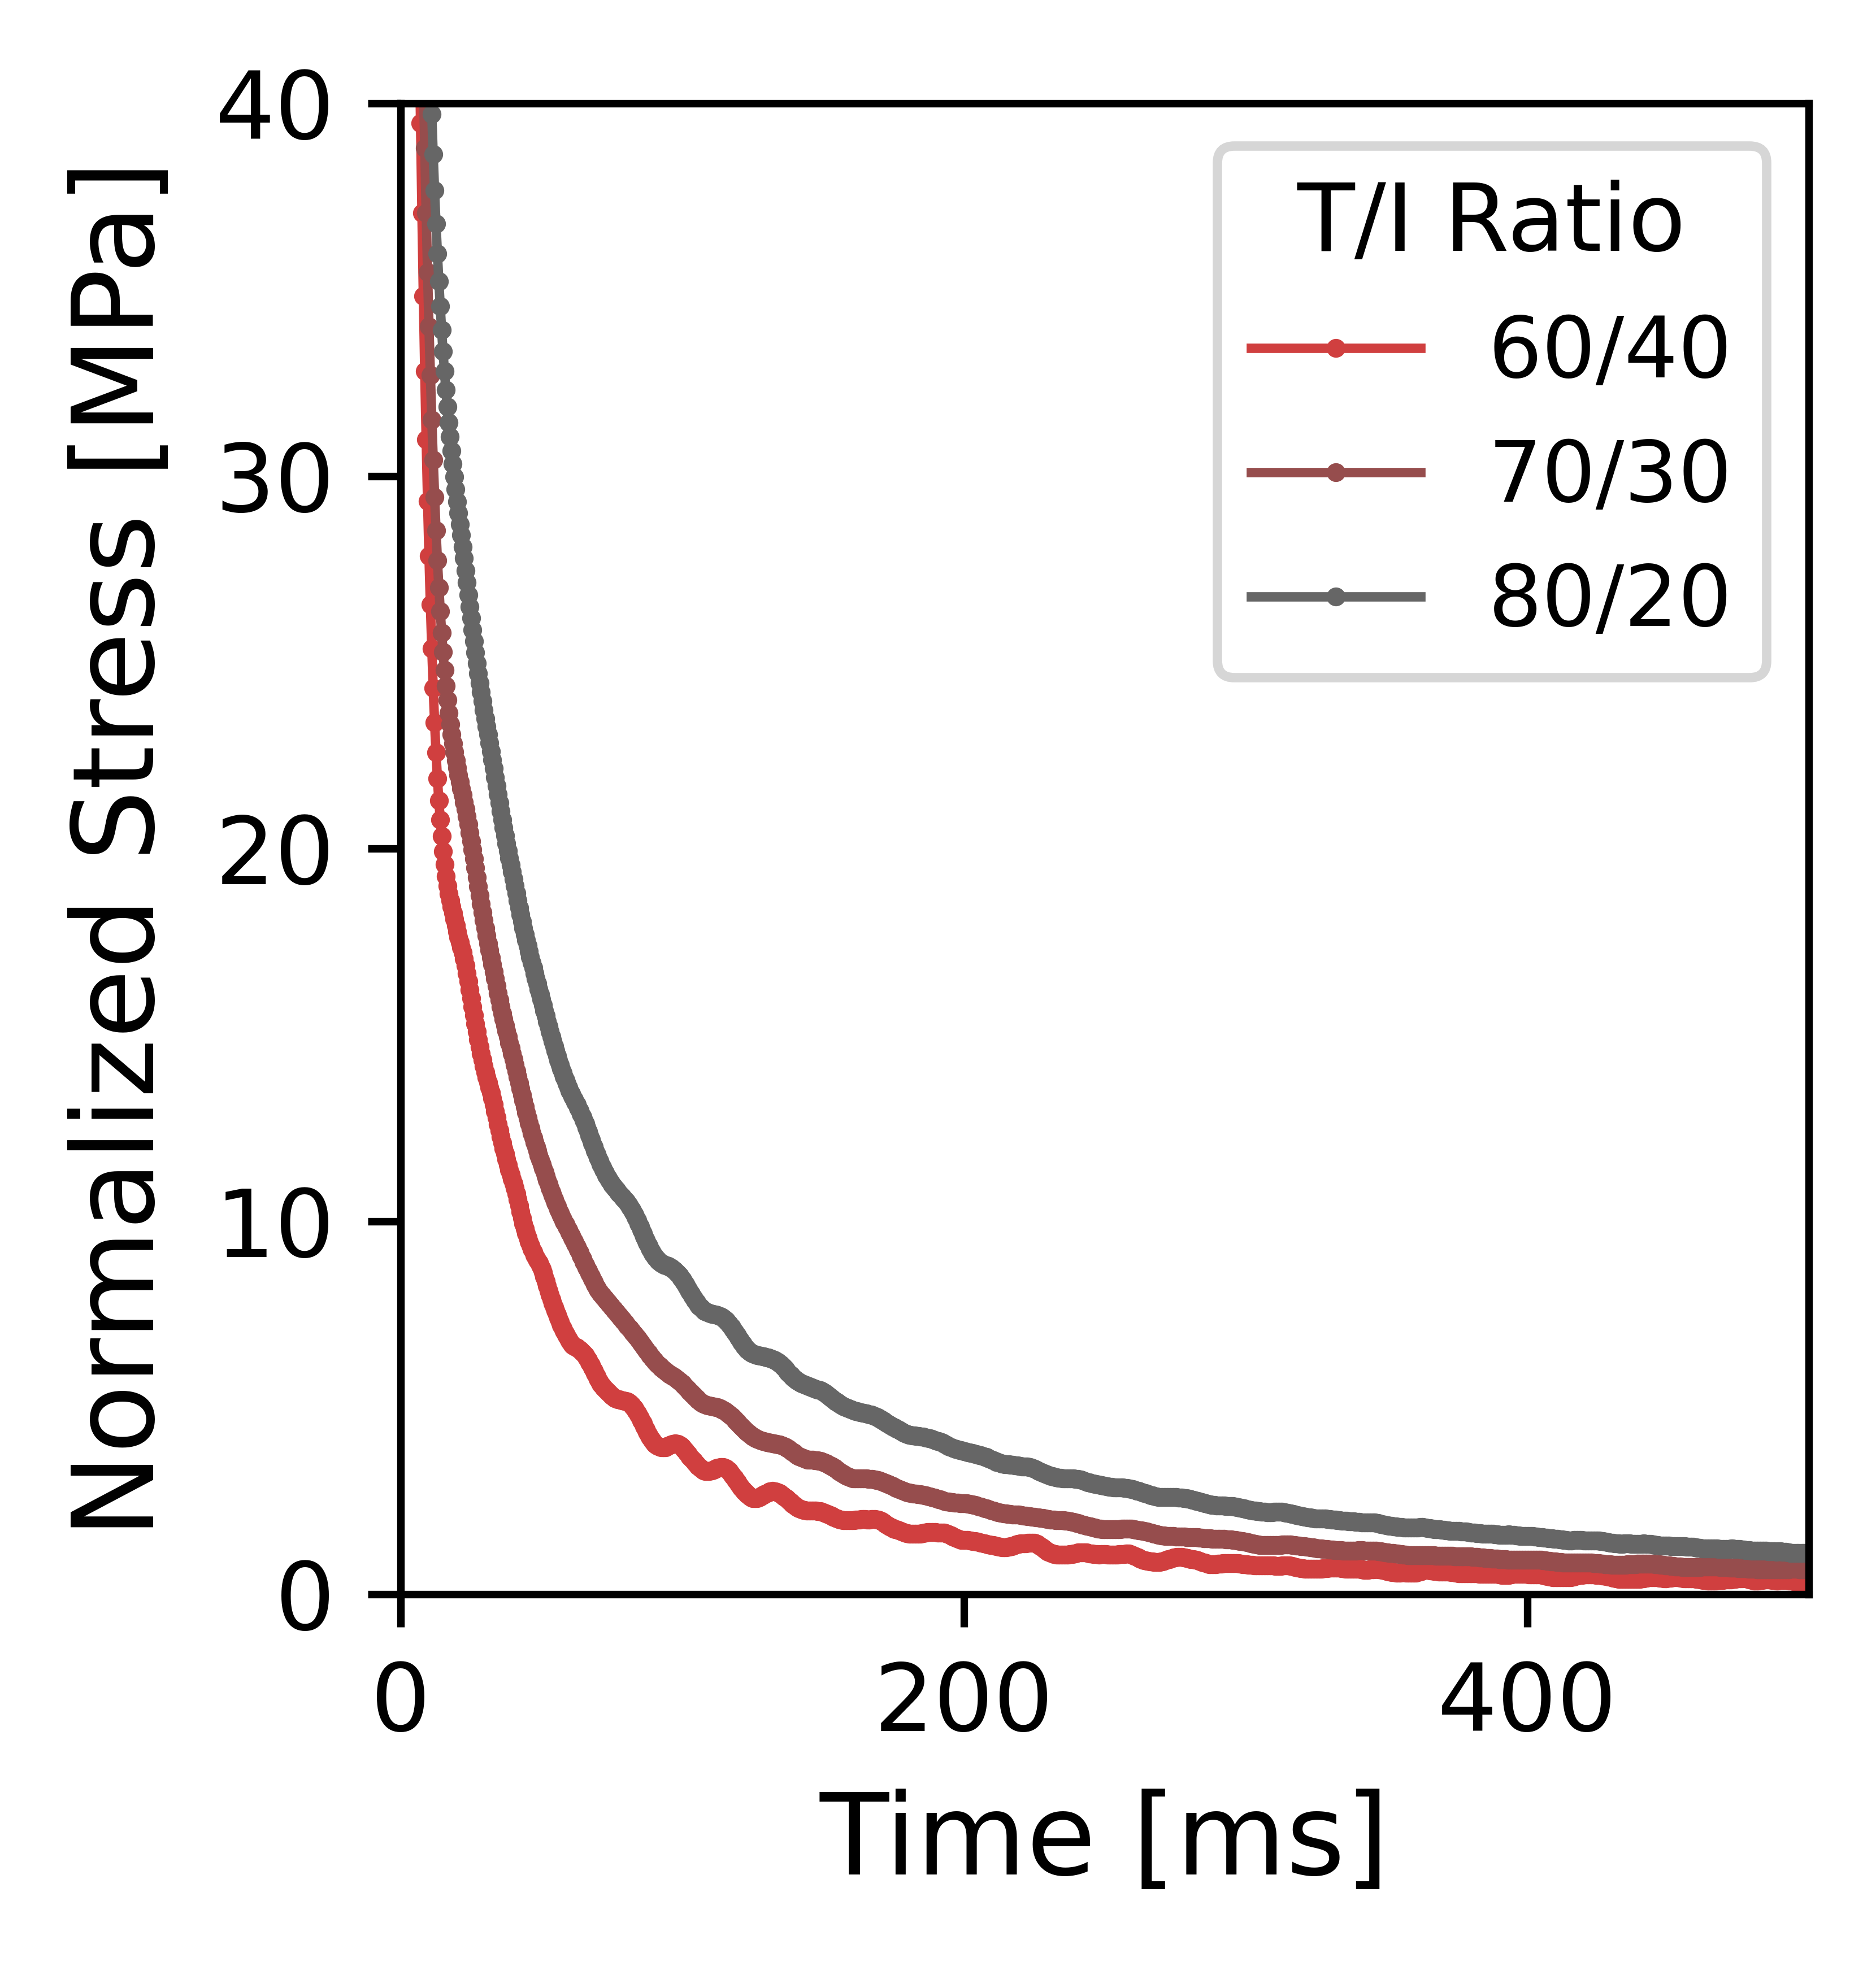

In [13]:
fpath = "../experimental-stress-data/csv"
for ti_ratio in ["6040", "7030", "8020"]:
    data = np.loadtxt(os.path.join(fpath, f"usm-stress-strain-data-{ti_ratio}.csv"), delimiter=",")
    if ti_ratio == str(6040):
        label="60/40"
        _ti_ratio = 0.60
    elif ti_ratio == str(7030):
        label="70/30"
        _ti_ratio = 0.70
    elif ti_ratio == str(8020):
        label="80/20"
        _ti_ratio = 0.80

    plt.plot(data[:,0], data[:,1], label=label, c=color_dict[_ti_ratio], marker="o", markersize=1)

plt.xlabel("Time [ms]")
plt.ylabel("Normalized Stress [MPa]")
plt.legend(title="T/I Ratio", fontsize=9)
plt.ylim(0, 40)
plt.xlim(0, 500)
plt.tight_layout()
plt.savefig("figures/exp-stress-decay.png")
plt.show()

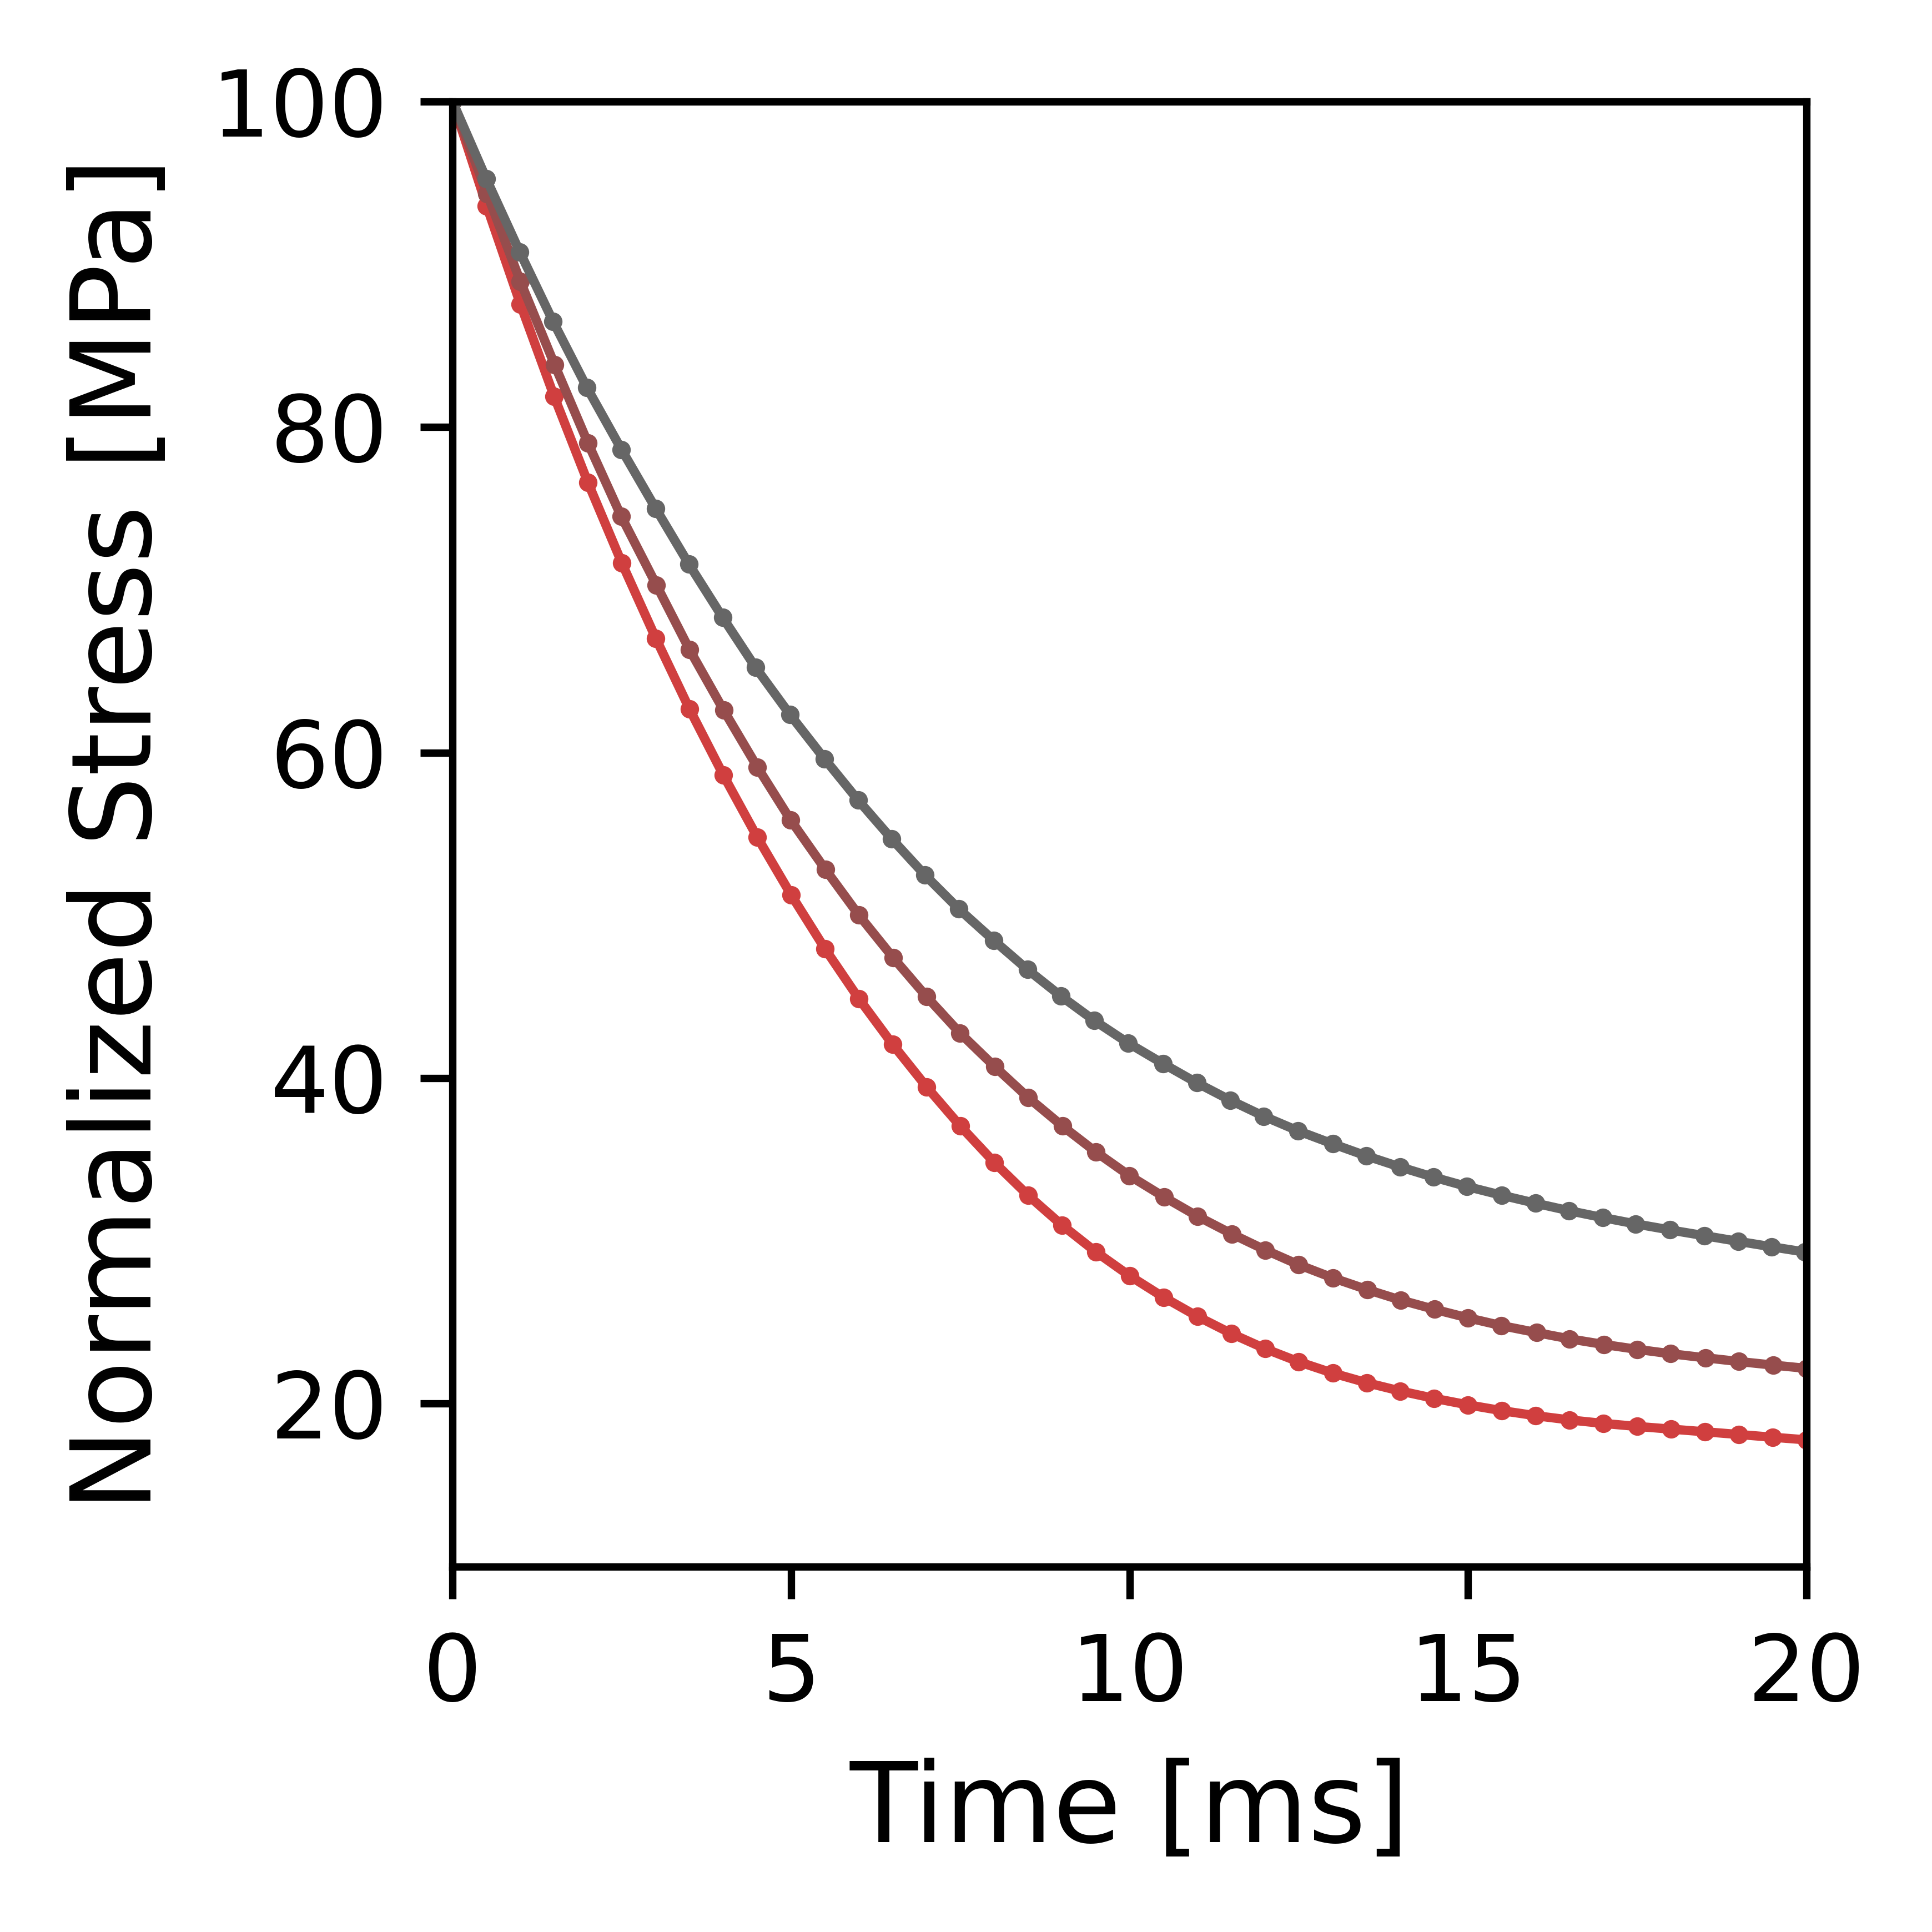

In [20]:
fpath = "../experimental-stress-data/csv"
for ti_ratio in ["6040", "7030", "8020"]:
    data = np.loadtxt(os.path.join(fpath, f"usm-stress-strain-data-{ti_ratio}.csv"), delimiter=",")
    if ti_ratio == str(6040):
        label="60/40"
        _ti_ratio = 0.60
    elif ti_ratio == str(7030):
        label="70/30"
        _ti_ratio = 0.70
    elif ti_ratio == str(8020):
        label="80/20"
        _ti_ratio = 0.80

    plt.plot(data[:,0], data[:,1], label=label, c=color_dict[_ti_ratio], marker="o", markersize=1)

plt.xlabel("Time [ms]")
plt.ylabel("Normalized Stress [MPa]")
#plt.legend(title="T/I Ratio", fontsize=9)
plt.ylim(10, 100)
plt.xlim(0, 20)
plt.tight_layout()
plt.savefig("figures/exp-stress-decay-short-time.png")
plt.show()

# End-to-End Distances

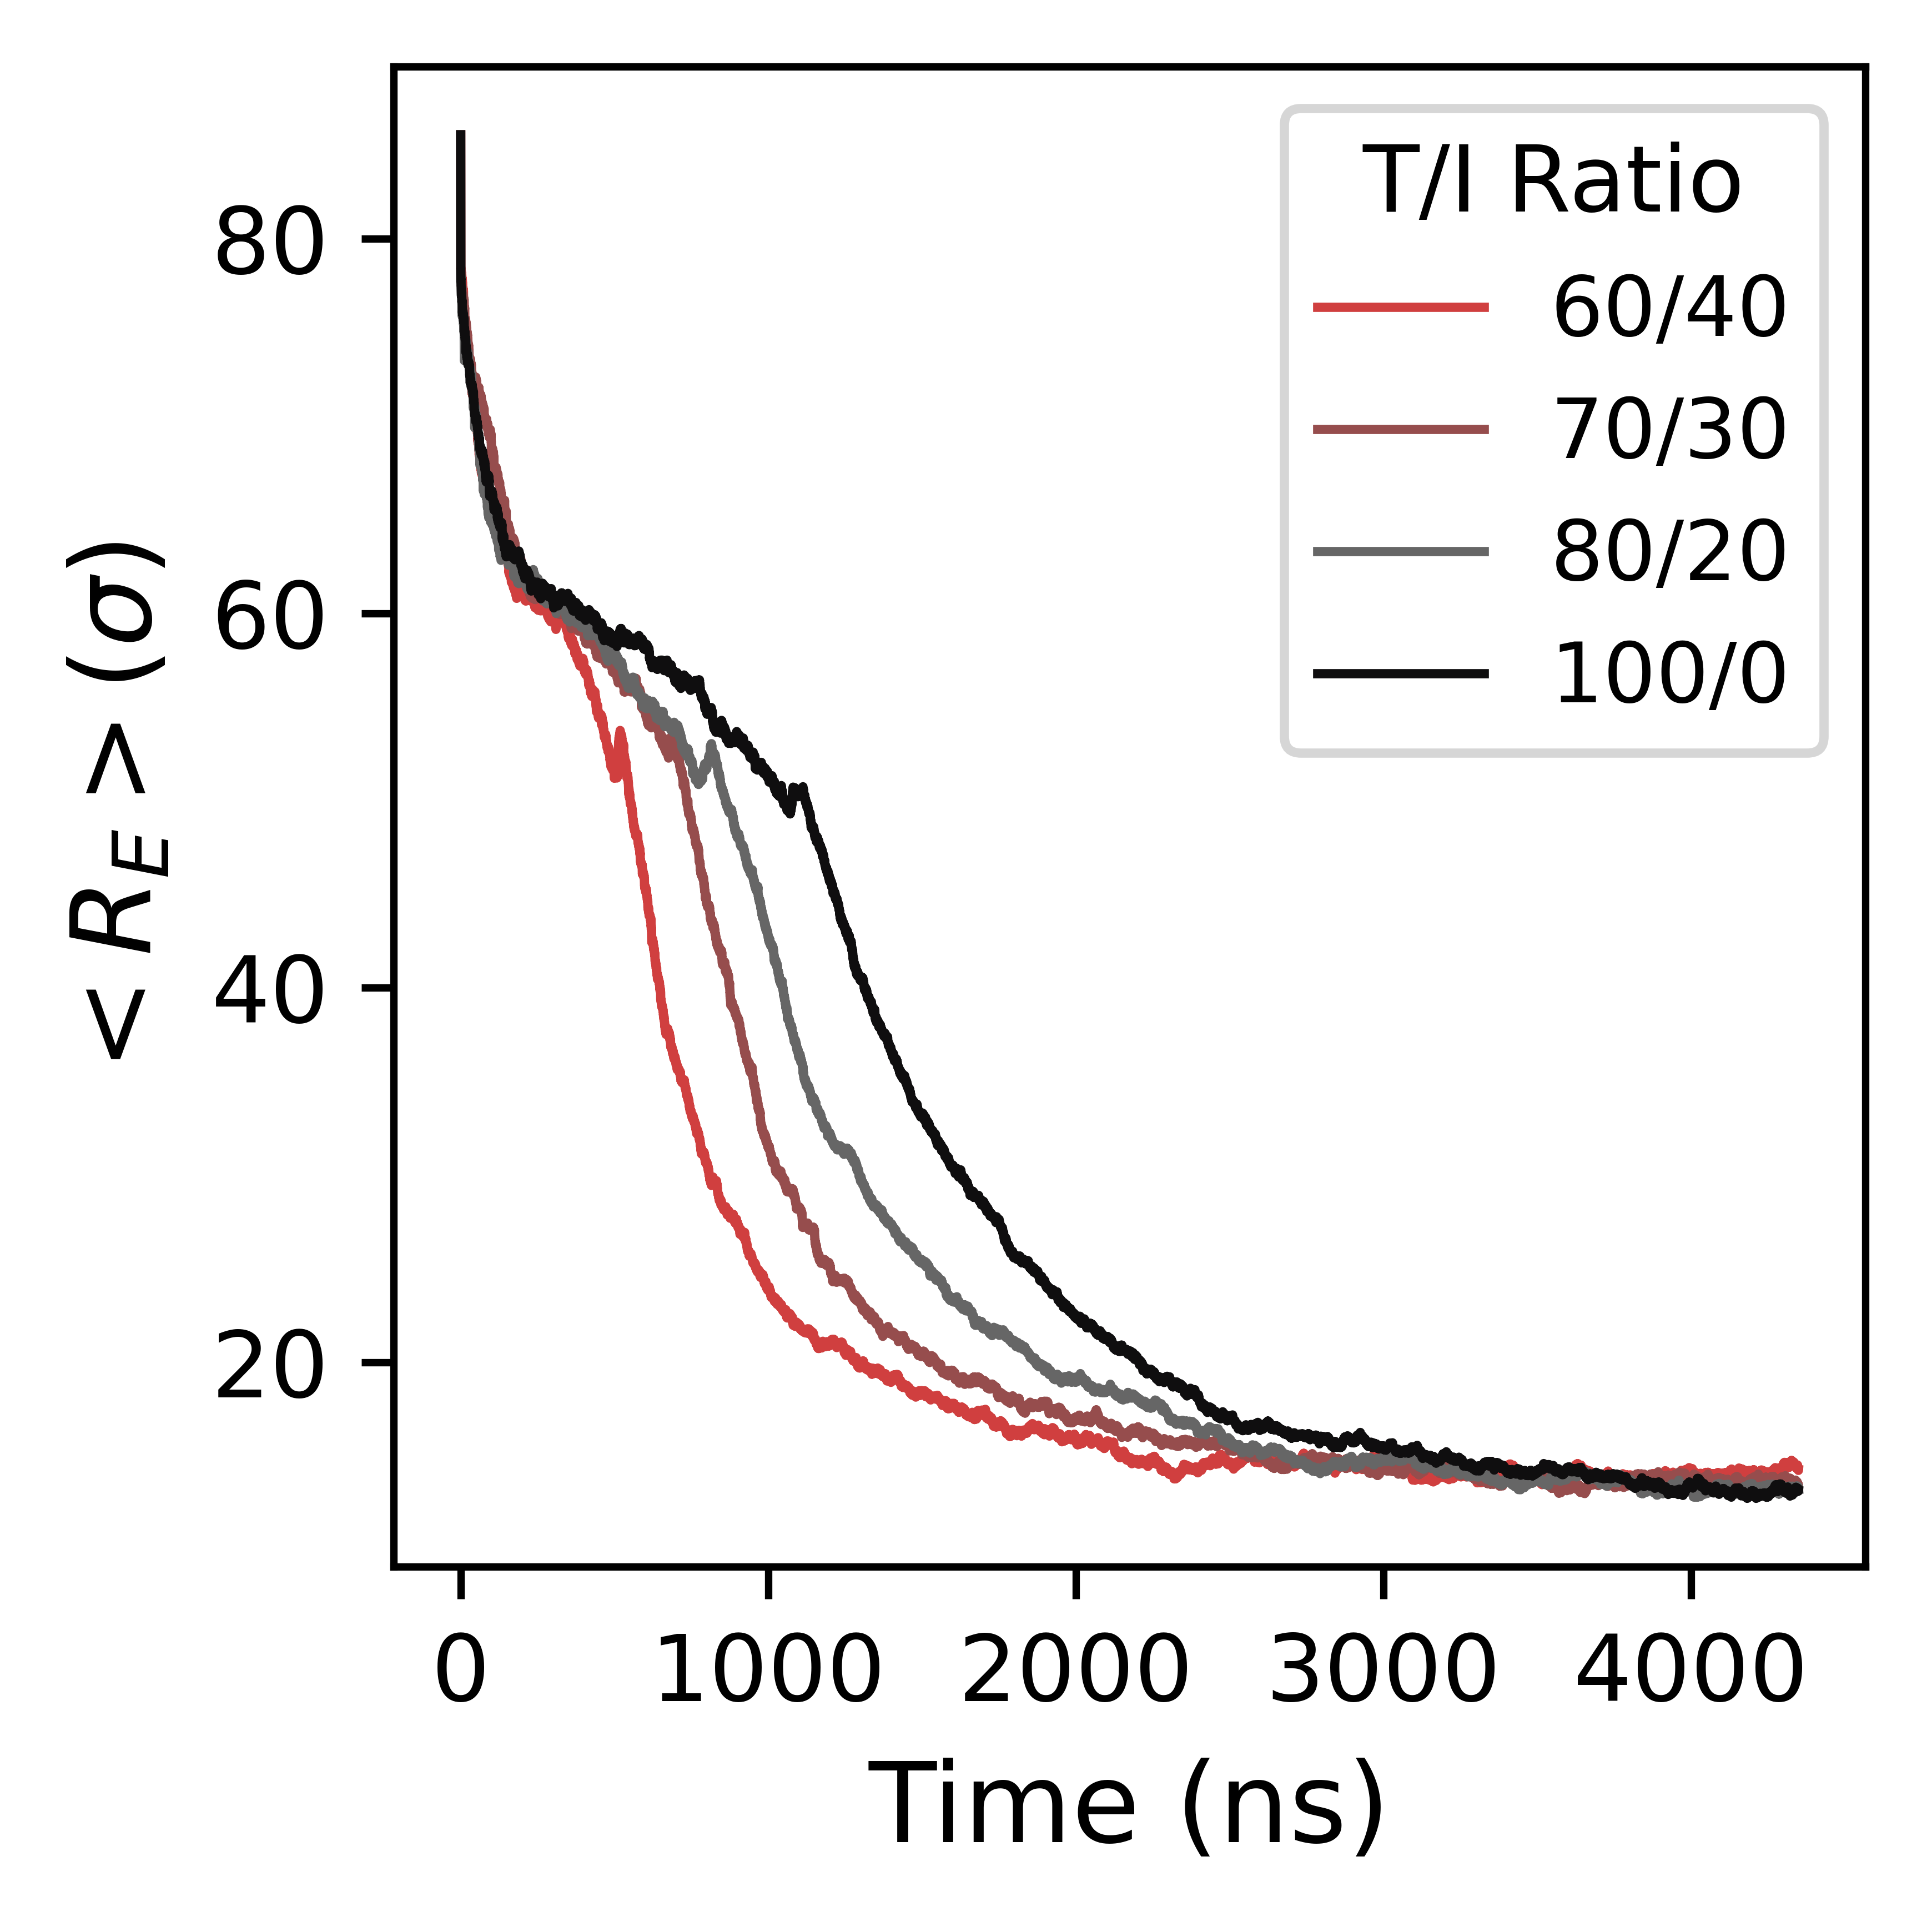

In [8]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"):            
    for job in jobs:
        if ti_ratio == 0.60:
            label="60/40"
        elif ti_ratio == 0.70:
            label="70/30"
        elif ti_ratio == 0.80:
            label="80/20"
        elif ti_ratio == 1.0:
            label="100/0"
        re_means = np.loadtxt(job.fn("re_means.txt"))
        re_stds = np.loadtxt(job.fn("re_stds.txt"))
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(re_means)), job.sp.gsd_write)
        plt.plot(ns, re_means, label=label, c=color_dict[ti_ratio])
        #plt.errorbar(x=ns, y=re_means, yerr=re_stds, marker="o")
        
plt.legend(title="T/I Ratio", fontsize=9)

plt.xlabel("Time (ns)")
plt.ylabel("$<R_E> (\sigma)$")
#plt.xlim(0, 500)
plt.tight_layout()
#plt.savefig(f"end-to-end-decay-{kT}kT.png")
plt.show()

# Mean Square Displacement:

In [ ]:
ua_results = {}
chunk_size=200
start_frame = 500
end_frame = 2000 - chunk_size
n_samples = 20

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"):  
    job = list(jobs)[0]
    with gsd.hoomd.open(job.fn("components.gsd")) as traj:
        end_frame = len(traj) - chunk_size
        random_starts = np.random.randint(start_frame, end_frame, n_samples)
        
    window_slopes = []
    steps_per_frame = job.doc.steps_per_frame
    ts = job.doc.real_timestep * 1e-15
    ts_frame = steps_per_frame * ts
    
    for i in random_starts:
        msd = msd_from_gsd(
            gsdfile=job.fn("components.gsd"),
            start=int(i),
            stop=int(i) + chunk_size,
            atom_types="all",
            msd_mode="direct"
        )
        
        msd_data = np.copy(msd.msd)
        msd_data *= 3.39**2 * 1e-20
        time = np.arange(0, chunk_size, 1) * ts_frame
        mid_chunk = msd_data[len(msd_data)//4:-len(msd_data)//4]
        mid_chunk_time = time[len(time)//4:-len(time)//4]
        window_slopes.append((mid_chunk[-1] - mid_chunk[0])/(mid_chunk_time[-1] - mid_chunk_time[0]))
        
    ua_results[job.doc.T_SI - 273] = [np.mean(window_slopes), np.std(window_slopes)]
    job.doc.D = np.mean(window_slopes)
    job.doc.D_std = np.std(window_slopes)
    job.doc.T_celsius = job.doc.T_SI - 273

In [25]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"):  
        for job in jobs:Square
            msd = msd_from_gsd(
                gsdfile=job.fn("sim_traj.gsd"),
                start=0,
                stop=-1,
                atom_types="all",
                msd_mode="direct"
            )
            ns = frames_to_ns(job.doc.real_timestep, range(0, len(msd.msd)), job.sp.gsd_write)
            data = np.vstack([ns, msd.msd])
            np.savetxt(fname=job.fn("msd.txt"), X=data.T, delimiter=",")
            print(job)


684609f96c9f66b53bb8cf16b9dabdbb
ffebf83348486c231726975386c8cc67
16682b9ef596ff381b625c9c66eb9036
082c6e91cce5471ac200cd69f128d5ef


<Figure size 3600x3600 with 0 Axes>

In [55]:
def line(power, x, b=0):
    return x**(power) + b

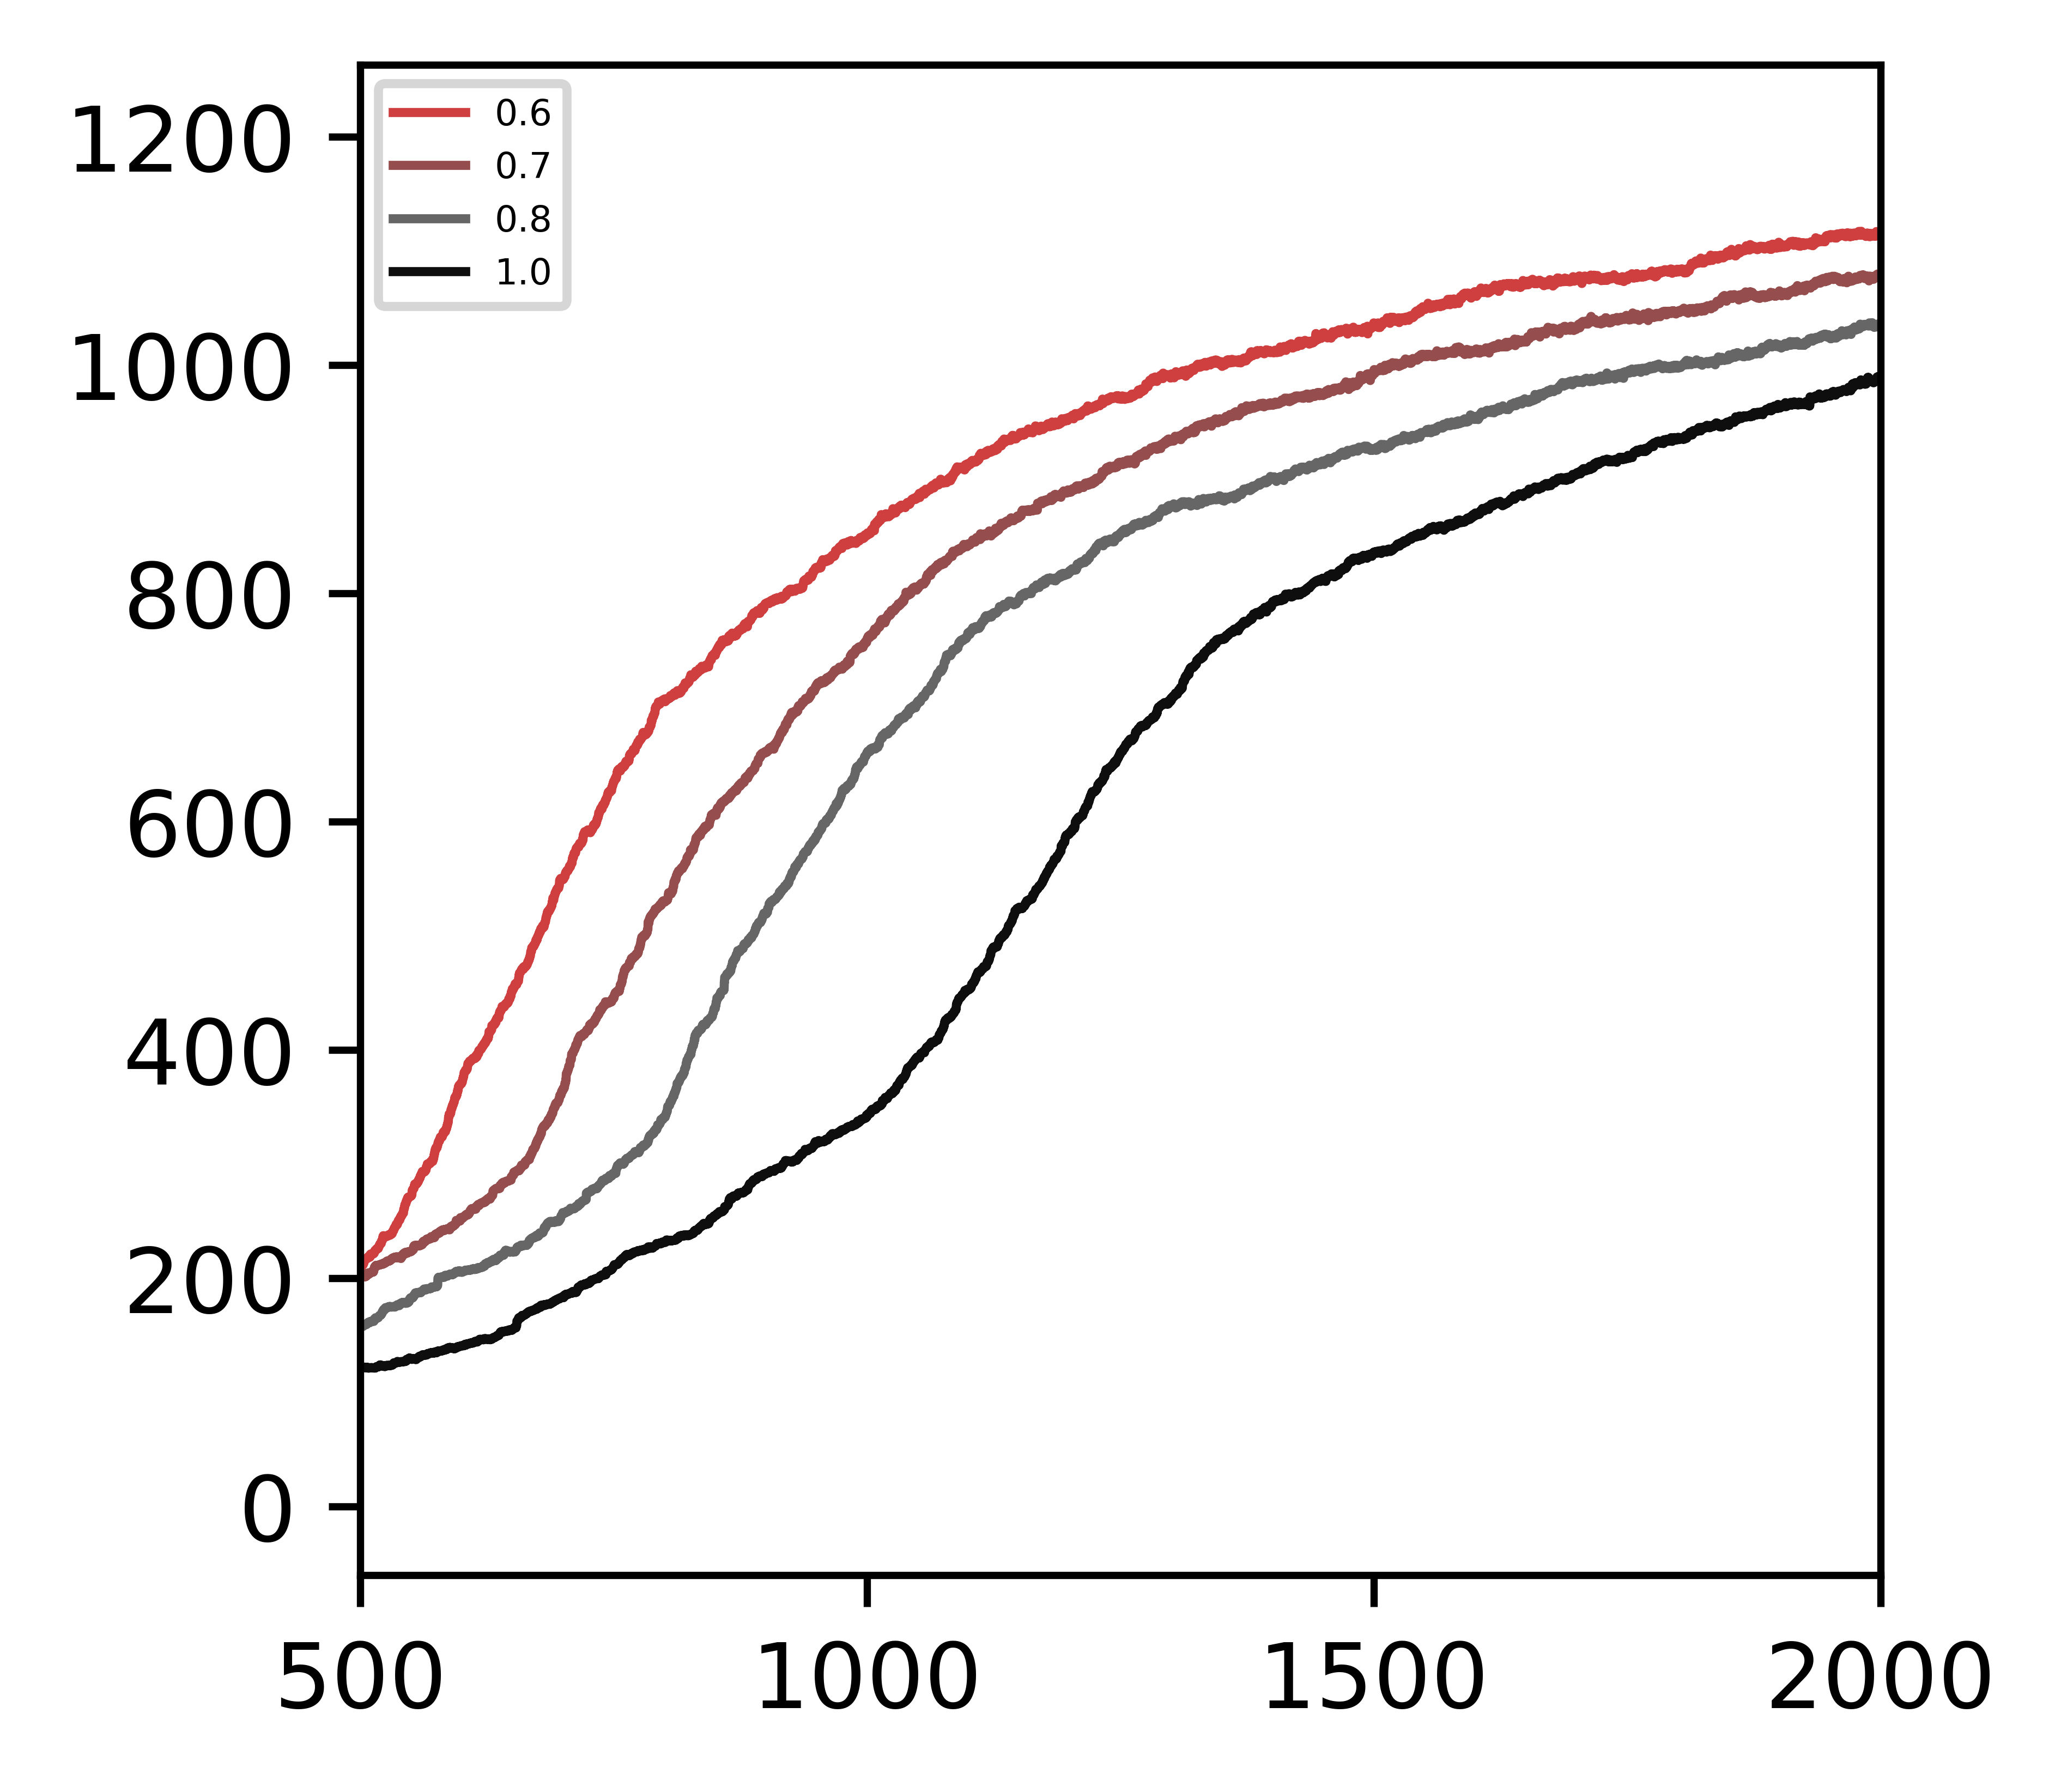

In [69]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": 2.0, "cg_potentials_dir": "msibi-deep"
    }).groupby("ekk_weight"):
        for job in jobs:
            msd = np.loadtxt(job.fn("msd.txt"), delimiter=",")
            plt.plot(msd[:,0], msd[:,1], label=ti_ratio, c=color_dict[ti_ratio])

plt.legend()
plt.xlim(500, 2000)
#plt.ylim(0, 1000)
plt.show()

# Pressure:

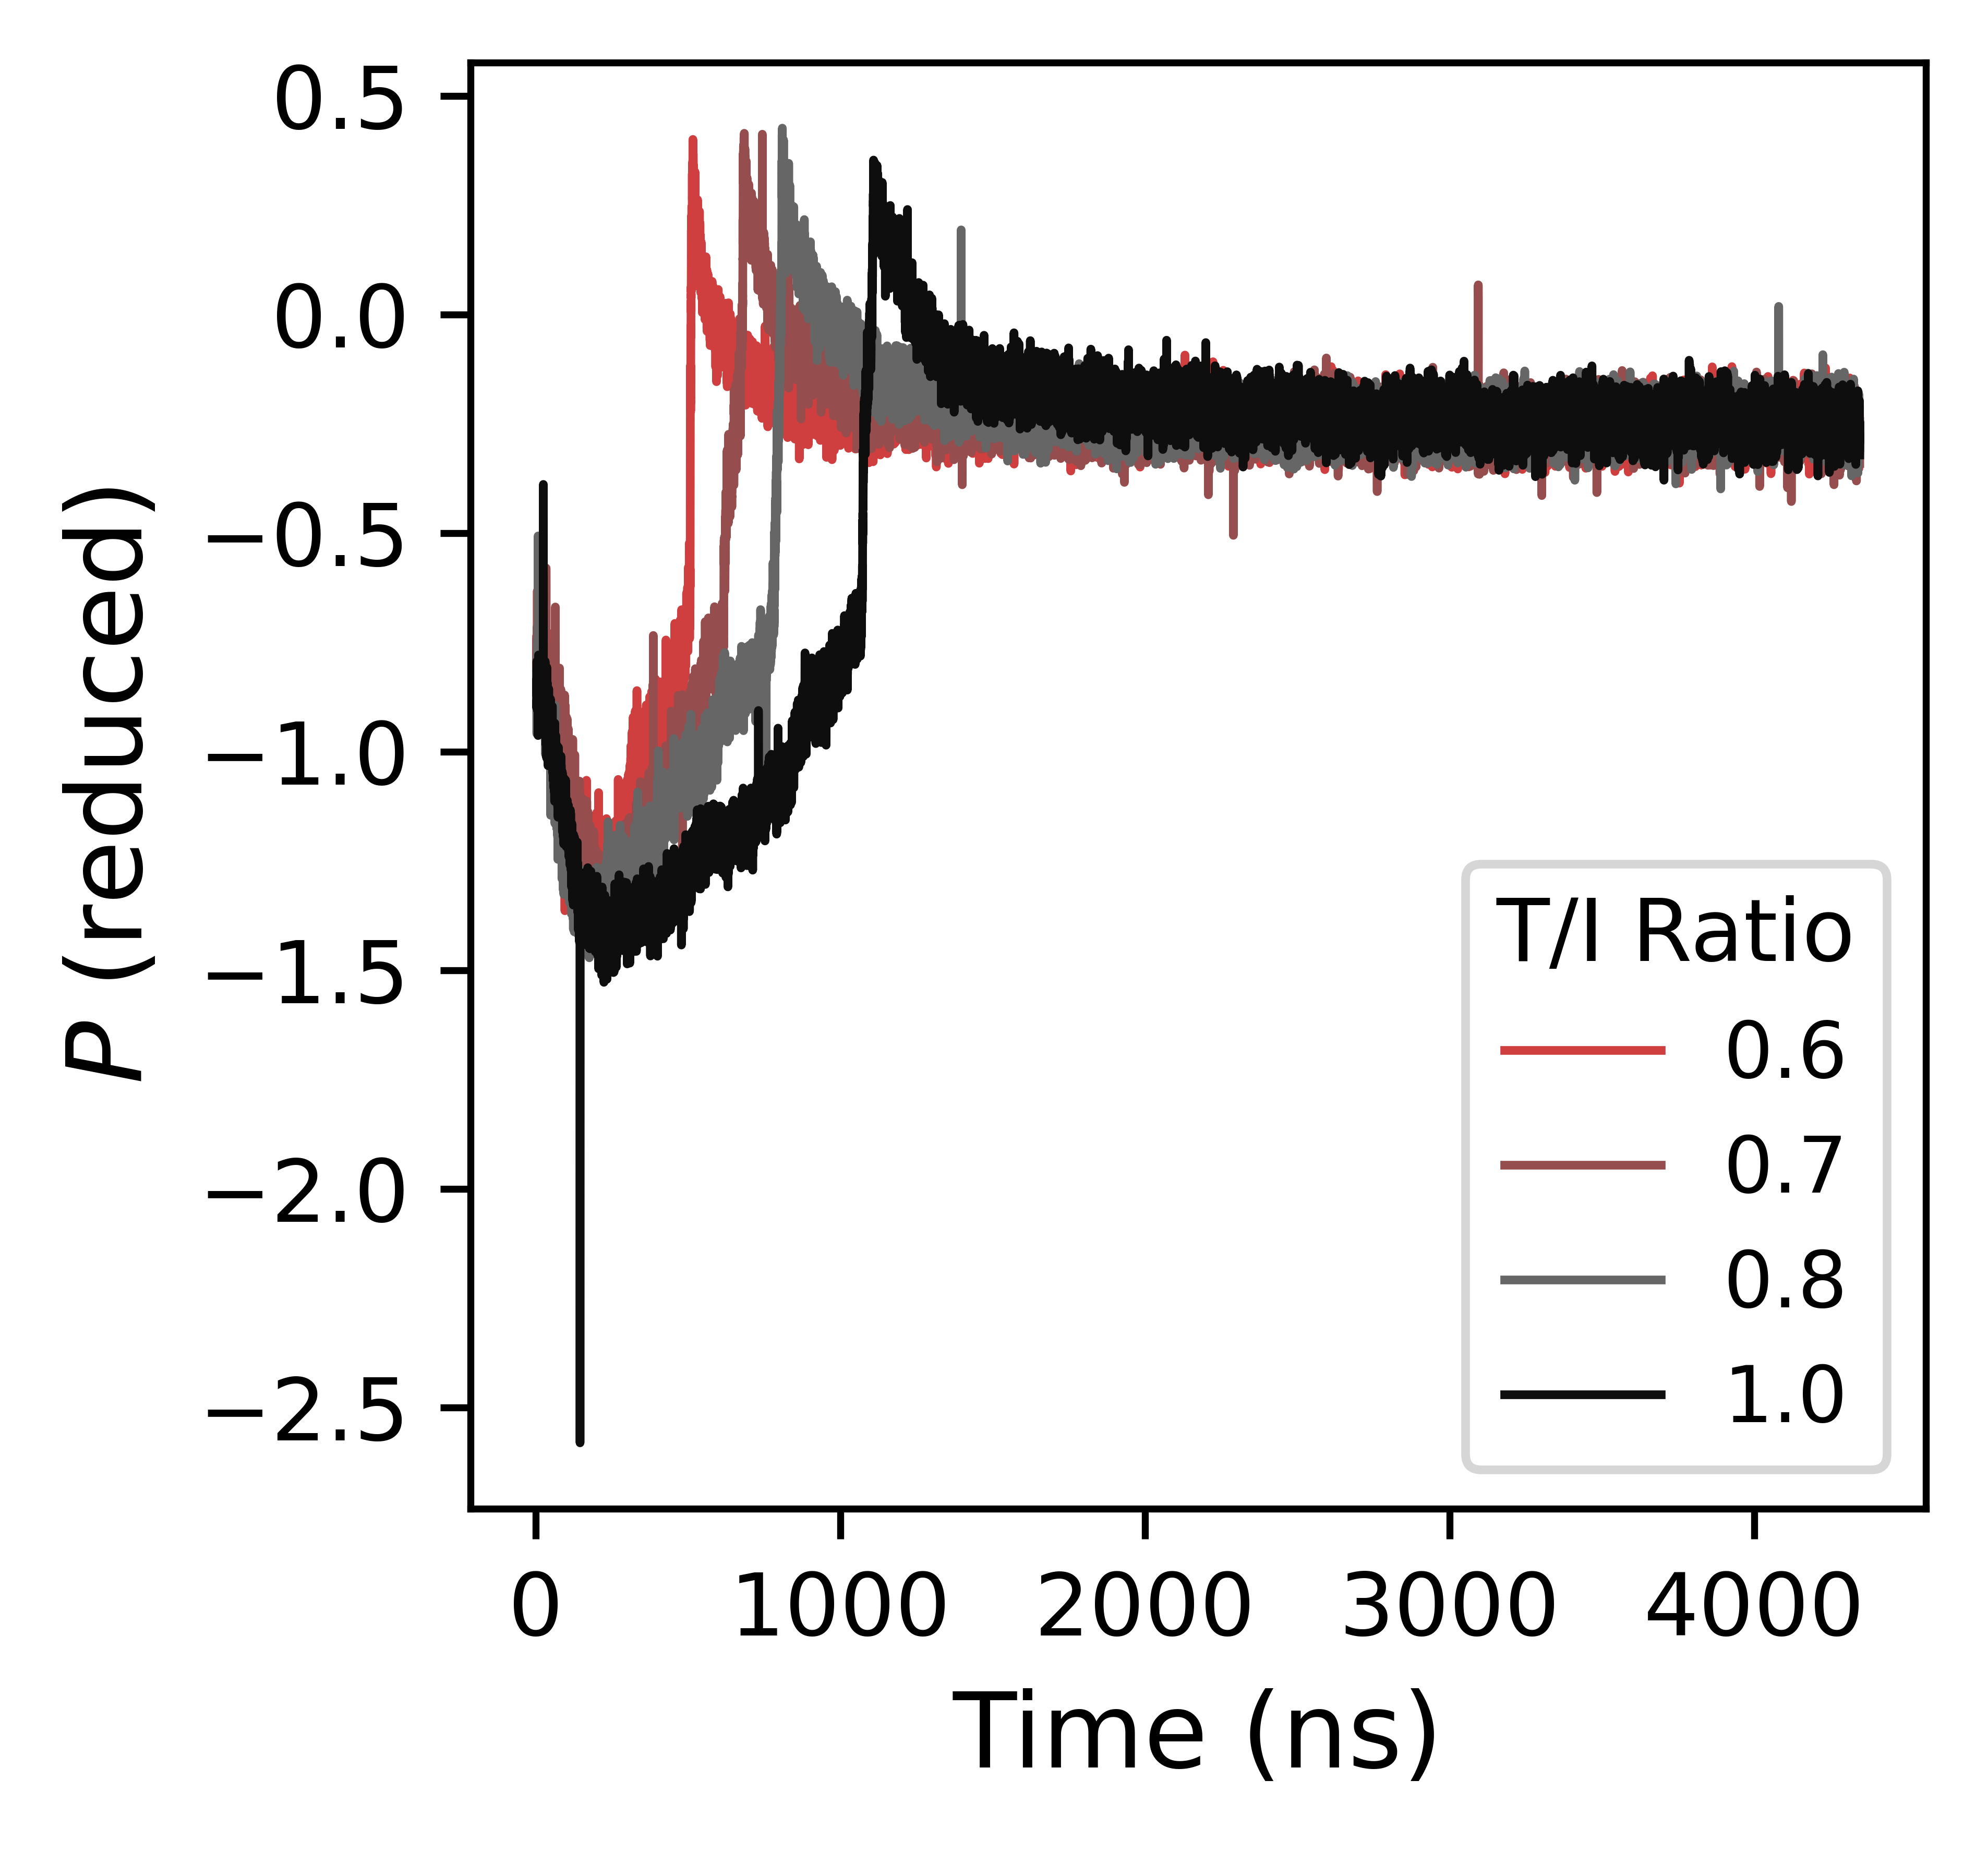

In [19]:
fig = plt.figure()

count = 0
for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"): 
    
    for job in jobs:
        data = np.genfromtxt(job.fn("sim_traj.txt"), names=True)
        pressure = data["mdcomputeThermodynamicQuantitiespressure"][200:]
        pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
        pressure = savitzky_golay(pressure, order=1, window_size=11)
        pe = savitzky_golay(pe, order=1, window_size=11)
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(pressure)), job.sp.log_write)
        plt.plot(ns[200:], -pressure[200:], label=ti_ratio, c=color_dict[ti_ratio])
        #plt.plot(ns[200:], pe[200:], label=ti_ratio, c=color_dict[ti_ratio])

        count += 0

plt.legend(title="T/I Ratio", fontsize=9, ncol=1)
#plt.ylim(-0.5, 1.6)
plt.xlabel("Time [ns]")
plt.ylabel("$P$ [reduced]")
plt.show()